# CIDEr etc.  and time for batch/learning rate combinations

### Logs with validation, 5 epochs, 2 runs

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [3]:
!ls -l logs/microseries/GTX_TITAN_X

total 0
drwxr-xr-x  42 peterbryzgalov  staff  1428 Apr  3 18:19 loss
drwxrwxr-x  86 peterbryzgalov  staff  2924 Apr  4 10:32 val_5epoch


In [4]:
logdir = "logs/microseries/GTX_TITAN_X/val_5epoch"

In [214]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

96

In [215]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind_e = 0 # DataFrame row number (index) for df_epochtime
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                if debug: print line,
                epoch = int(m2.group(1))
                time = float(m2.group(2))
                loss = float(m2.group(3))        
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df_epochtime.loc[ind_e] = [batch,learn,run,epoch,time,loss]
                ind_e += 1
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1
    return (df_epochtime, df_validation)

In [216]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [217]:
print logdir
df_epochtime,df_validation = readLogs(logdir)

logs/microseries/GTX_TITAN_X/val_5epoch


In [218]:
df_epochtime.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.0001,0.0,1.0,28.770715,6.783803
1,12.0,0.0001,0.0,2.0,28.271511,6.736244
2,12.0,0.0001,0.0,3.0,28.257501,6.840549
3,12.0,0.0001,0.0,4.0,28.153150,6.745804
4,12.0,0.0001,0.0,5.0,178.479423,6.716468


## Validation score

In [219]:
print df_validation.shape
df_validation.head()

(96, 9)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12.0,0.0001,0.0,0.063412,0.007551,0.002497,1.625705e-07,0.176805,0.000790
1,12.0,0.0001,1.0,0.087691,0.016207,0.006624,1.207068e-03,0.106612,0.000627
2,12.0,0.0005,0.0,0.165756,0.079217,0.047427,2.858176e-02,0.184995,0.054896
3,12.0,0.0005,1.0,0.098526,0.044929,0.022745,1.156937e-02,0.133780,0.040090
4,12.0,0.0010,0.0,0.115516,0.058408,0.035503,2.337302e-02,0.161119,0.059703


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b482890>]], dtype=object)

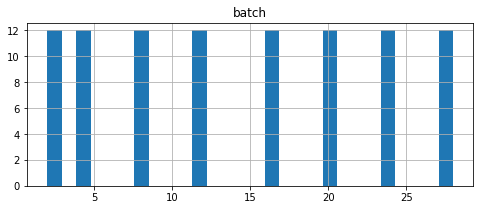

In [221]:
plt.rcParams['figure.figsize'] = 8,3
df_validation[["batch"]].hist(bins=28)

In [226]:
# Two runs with same hyperparameters have quite! different scores
df_tmp = df_validation[(df_validation["batch"] == 28)]
df_tmp

,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
48,28.0,0.0001,0.0,0.127393,0.008491,0.002146,9.941714e-04,0.143081,0.000808
49,28.0,0.0001,1.0,0.144451,0.020857,0.002970,1.290096e-07,0.157884,0.000597
50,28.0,0.0005,0.0,0.160073,0.087990,0.054060,3.514061e-02,0.213769,0.110500
51,28.0,0.0005,1.0,0.152996,0.091523,0.061830,4.380158e-02,0.204717,0.112778
52,28.0,0.0010,0.0,0.250319,0.146340,0.096696,6.755722e-02,0.234559,0.139817
53,28.0,0.0010,1.0,0.347804,0.222749,0.155309,1.115645e-01,0.285936,0.167153
54,28.0,0.0020,0.0,0.367075,0.236408,0.157001,1.087505e-01,0.307329,0.162037
55,28.0,0.0020,1.0,0.151335,0.085893,0.055856,3.815141e-02,0.211880,0.111549
56,28.0,0.0030,0.0,0.334300,0.221775,0.159415,1.165738e-01,0.273272,0.150516
57,28.0,0.0030,1.0,0.252822,0.159375,0.108534,7.671801e-02,0.271778,0.136807


In [227]:
df_tmp = pd.melt(df_tmp, id_vars=['batch', 'lr','run'])
df_tmp = df_tmp.drop(["batch"], axis=1)
df_tmp.head()

,lr,run,variable,value
0,0.0001,0.0,bleu1,0.127393
1,0.0001,1.0,bleu1,0.144451
2,0.0005,0.0,bleu1,0.160073
3,0.0005,1.0,bleu1,0.152996
4,0.0010,0.0,bleu1,0.250319


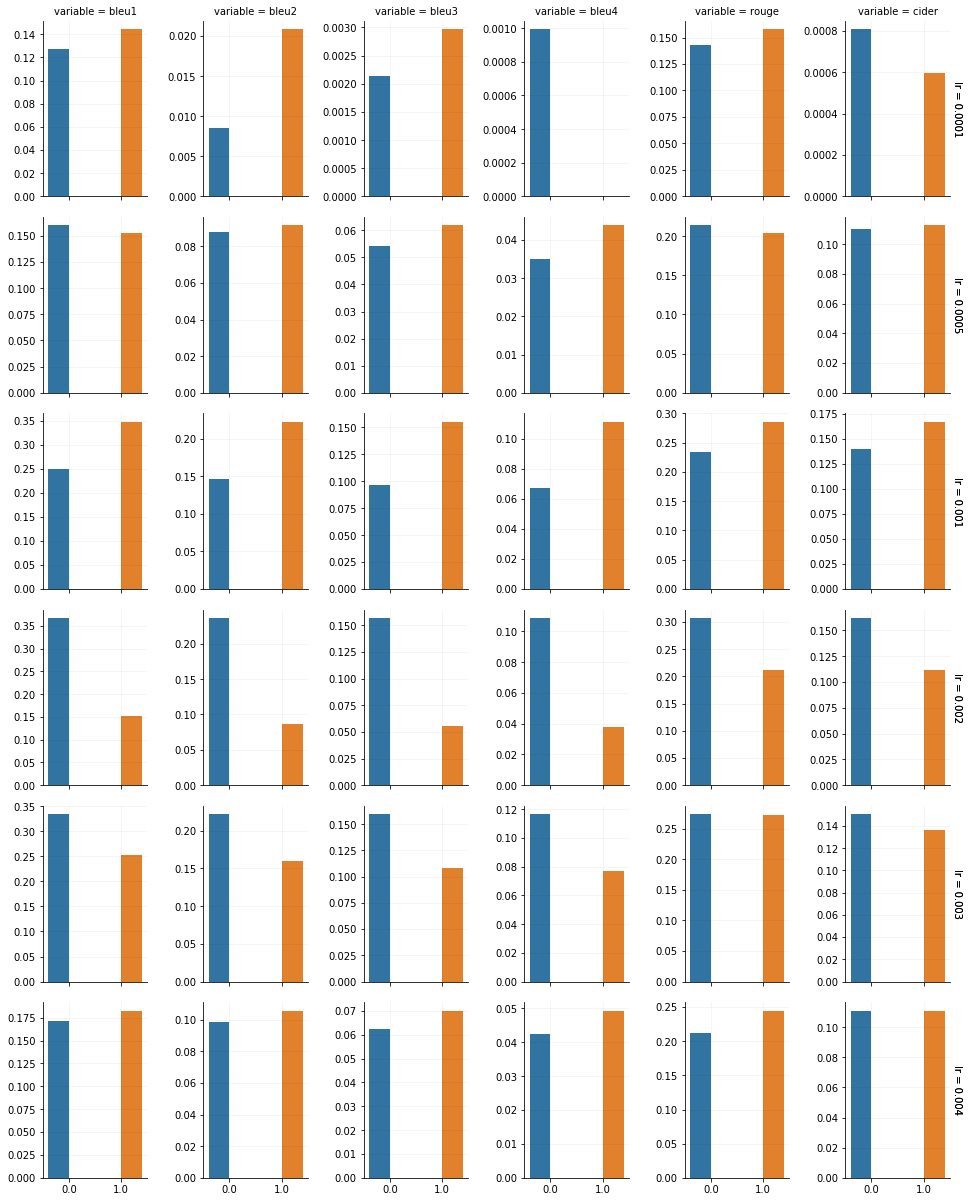

In [229]:
fg = sns.factorplot(x="run", y="value",row="lr",col="variable",hue="run",data=df_tmp, kind="bar",
                    legend=True,size=2.8,aspect=.8,sharey = False,margin_titles=True)
fg.map(plt.grid,alpha=.04,linewidth=0.5,aa=False,color="black")
plt.show()

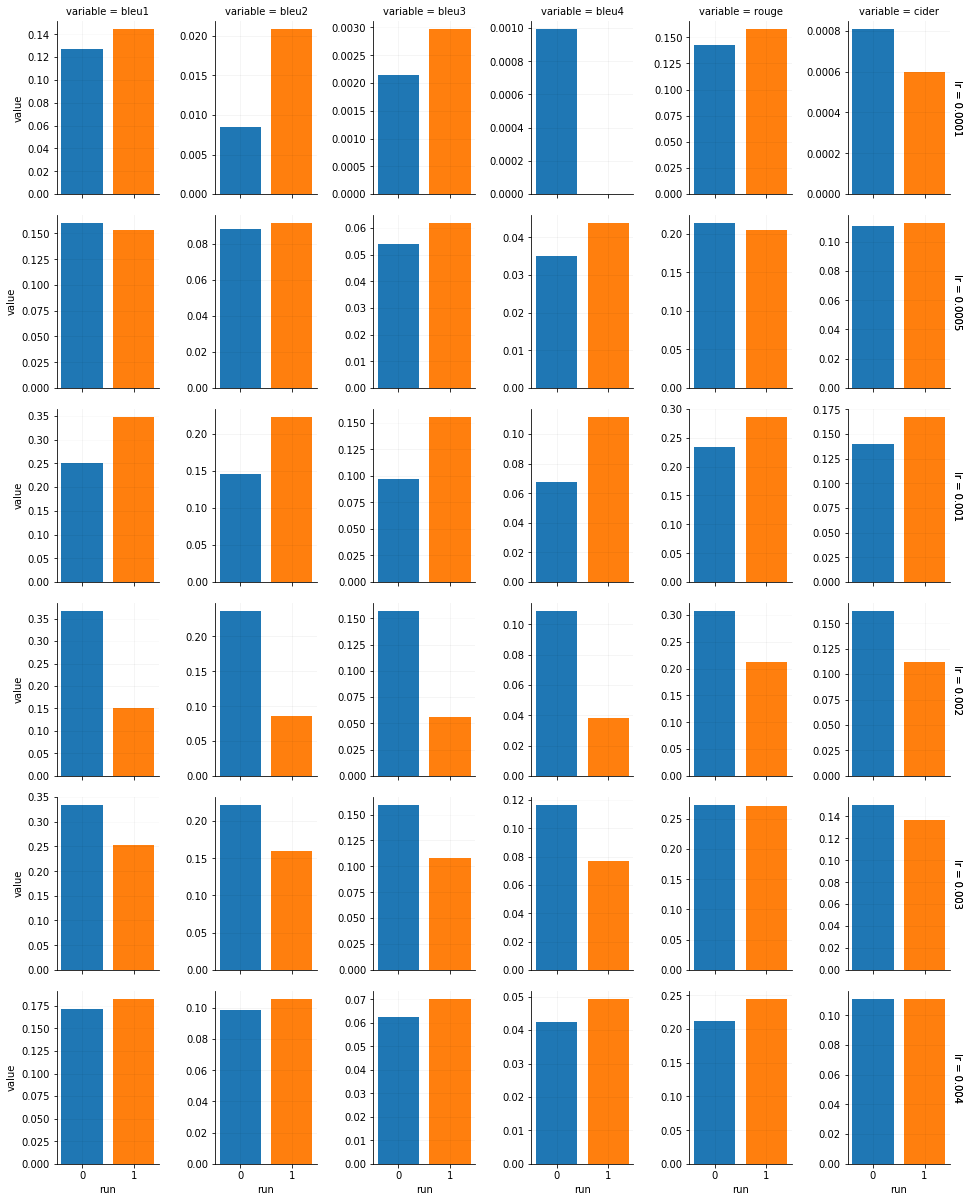

In [231]:
fg = sns.FacetGrid(df_tmp,col="variable",row="lr",hue="run",size=2.8,aspect=.8,sharey=False, margin_titles=True)
fg.map(plt.grid,alpha=.04,linewidth=0.5,aa=False,color="black")
fg.map(plt.bar,"run","value")
plt.show()

In [232]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,2.0,0.0001,0.052103,0.004103,0.001338,1.104573e-07,0.166016,0.000404
1,2.0,0.0005,0.065939,0.006768,0.001691,1.160884e-07,0.171395,0.001476
2,2.0,0.0010,0.035672,0.013556,0.009376,5.179084e-03,0.143157,0.007709
3,2.0,0.0020,0.060326,0.048152,0.034763,2.538725e-02,0.216742,0.012388
4,2.0,0.0030,0.004416,0.002683,0.002291,2.083545e-03,0.134478,0.003903


In [254]:
df_cider = df_mean.pivot_table(index="batch",columns="lr",values="cider")
df_rouge = df_mean.pivot_table(index="batch",columns="lr",values="rouge")
df_blue1 = df_mean.pivot_table(index="batch",columns="lr",values="bleu1")
df_blue2 = df_mean.pivot_table(index="batch",columns="lr",values="bleu2")
df_blue3 = df_mean.pivot_table(index="batch",columns="lr",values="bleu3")
df_blue4 = df_mean.pivot_table(index="batch",columns="lr",values="bleu4")
df_cider.head()

lr,0.0001,0.0005,0.001,0.002,0.003,0.004
batch,,,,,,
2.0,0.000404,0.001476,0.007709,0.012388,0.003903,0.000714
4.0,0.000238,0.006308,0.033892,0.002931,0.021530,0.003931
8.0,0.000089,0.038339,0.056975,0.058372,0.082135,0.056352
12.0,0.000708,0.047493,0.068230,0.073707,0.077560,0.047820
16.0,0.000790,0.047047,0.052103,0.059641,0.088530,0.082299


In [375]:
def plotHeatMap(df,ax,title=None,cmap=None):        
    cmesh=ax.pcolormesh(df,cmap=cmap)
    fig.colorbar(mappable=cmesh,ax=ax)    
    ax.set_yticks(np.arange(0.5, len(df.index), 1))
    ax.set_yticklabels(df.index)
    ax.set_xticks(np.arange(0.5, len(df.columns), 1))
    ax.set_xticklabels(df.columns)
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                ax.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.3, 'pad':0})
    ax.set_title(title,fontsize=18)

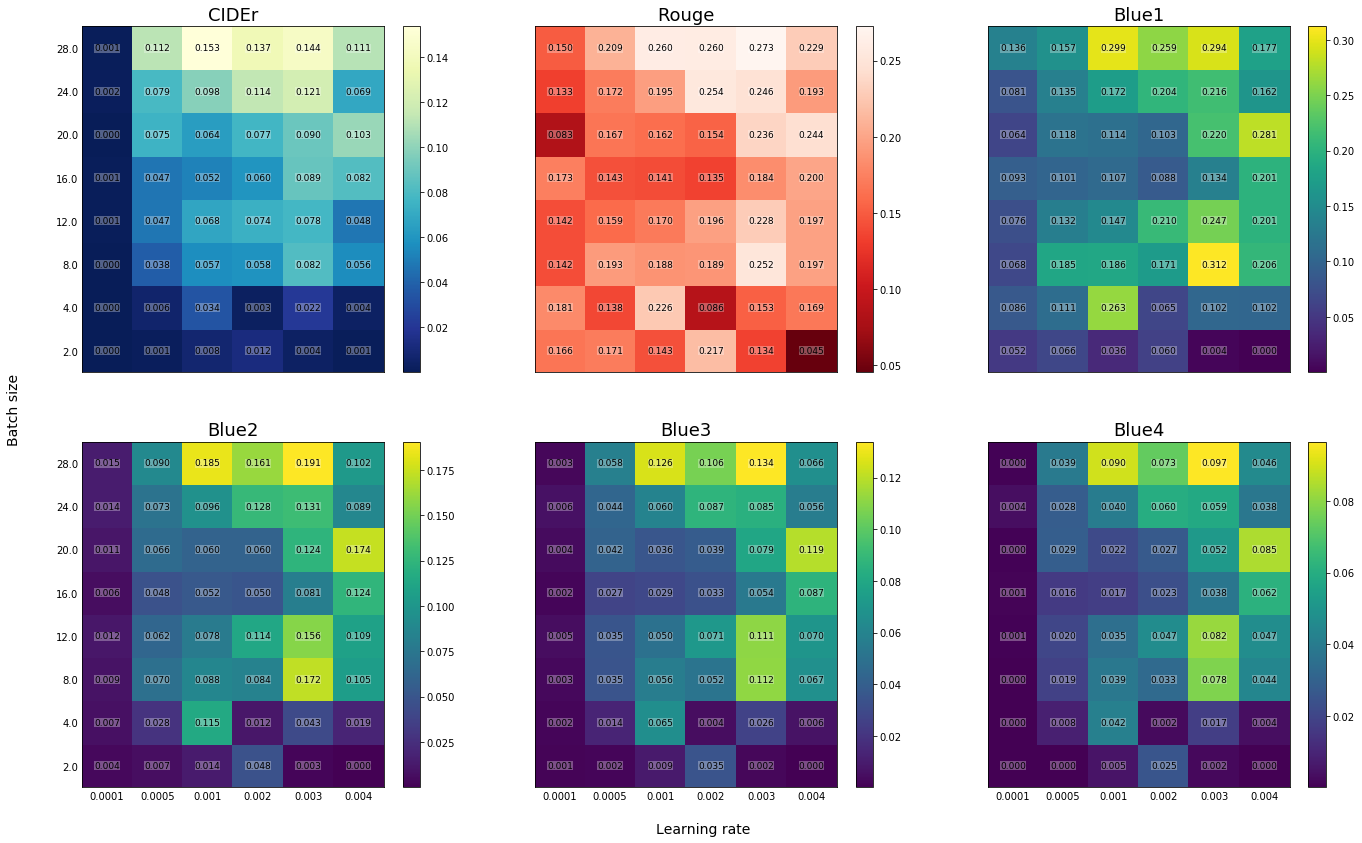

In [377]:
plt.rcParams['figure.figsize'] = 23,14
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
plotHeatMap(df_cider,ax[0,0],"CIDEr","YlGnBu_r")
plotHeatMap(df_rouge,ax[0,1],"Rouge","Reds_r")
plotHeatMap(df_blue1,ax[0,2],"Blue1")
plotHeatMap(df_blue2,ax[1,0],"Blue2")
plotHeatMap(df_blue3,ax[1,1],"Blue3")
plotHeatMap(df_blue4,ax[1,2],"Blue4")
fig.text(0.5, 0.08, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Batch size', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and time

In [99]:
df_epochtime.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.0001,0.0,1.0,28.770715,6.783803
1,12.0,0.0001,0.0,2.0,28.271511,6.736244
2,12.0,0.0001,0.0,3.0,28.257501,6.840549
3,12.0,0.0001,0.0,4.0,28.153150,6.745804
4,12.0,0.0001,0.0,5.0,178.479423,6.716468


In [101]:
df_1 = df_epochtime[df_epochtime["epoch"]==1.]
df_5 = df_epochtime[df_epochtime["epoch"]==5.]
df_5[df_5["batch"]==4.]

,batch,lr,run,epoch,time,loss
304,4.0,0.0001,0.0,5.0,830.994851,6.735716
309,4.0,0.0001,1.0,5.0,799.687669,6.733641
314,4.0,0.0005,0.0,5.0,582.679027,6.565802
319,4.0,0.0005,1.0,5.0,689.024660,6.709901
324,4.0,0.0010,0.0,5.0,527.470742,6.522255
329,4.0,0.0010,1.0,5.0,560.820176,6.693952
334,4.0,0.0020,0.0,5.0,592.952437,6.661306
339,4.0,0.0020,1.0,5.0,533.110756,6.764889
344,4.0,0.0030,0.0,5.0,593.300801,6.682460
349,4.0,0.0030,1.0,5.0,544.352249,7.121977


In [204]:
# Take average between runs
df_5mean = df_5.groupby(["batch","lr","epoch"]).mean().reset_index()
print df_5mean.head()
df_1mean = df_1.groupby(["batch","lr","epoch"]).mean().reset_index()
df_1mean = df_1mean.drop(["epoch","run","loss"],axis=1)
df_5mean = df_5mean.drop(["epoch","run","time"],axis=1)
df_5mean.head()

   batch      lr  epoch  run         time      loss
0    2.0  0.0001    5.0  0.5  1225.276355  7.010803
1    2.0  0.0005    5.0  0.5  1422.552907  6.893285
2    2.0  0.0010    5.0  0.5  1440.263267  7.065421
3    2.0  0.0020    5.0  0.5  1465.494914  6.801889
4    2.0  0.0030    5.0  0.5  1468.469971  6.803375


,batch,lr,loss
0,2.0,0.0001,7.010803
1,2.0,0.0005,6.893285
2,2.0,0.0010,7.065421
3,2.0,0.0020,6.801889
4,2.0,0.0030,6.803375


In [202]:
time_T = df_1mean.pivot_table(index="batch",columns="lr",values="time")
loss_T = df_5mean.pivot_table(index="batch",columns="lr",values="loss")

In [203]:
time_T.head()

lr,0.0001,0.0005,0.001,0.002,0.003,0.004
batch,,,,,,
2.0,13.379608,13.893378,13.745342,14.774141,14.521338,14.527493
4.0,16.966497,19.069842,17.910679,17.232583,18.069910,17.176047
8.0,22.577601,22.500802,23.437482,22.852215,23.001638,23.199348
12.0,28.847575,28.934748,29.484864,28.308347,28.541388,28.938816
16.0,36.552529,36.505376,36.350690,36.071117,36.028616,36.331203


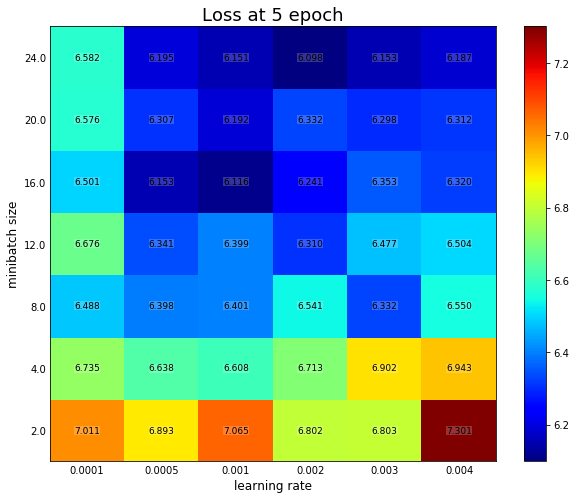

In [105]:
plotHeatMap(loss_T,"Loss at 5 epoch","jet")

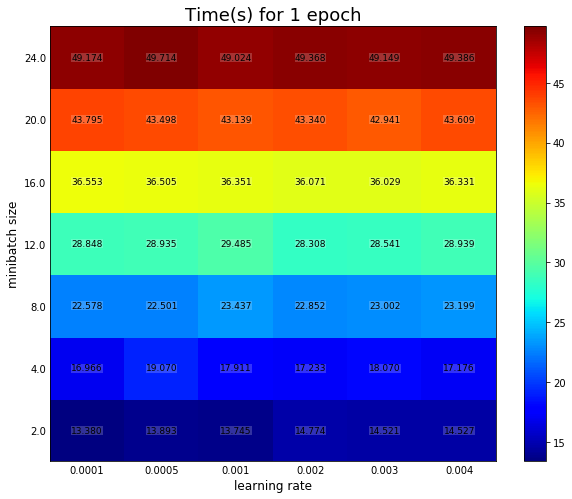

In [106]:
plotHeatMap(time_T,"Time(s) for 1 epoch","jet")